In [134]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype

from matplotlib import pyplot as plt
import numpy as np
import time

In [124]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [125]:
transforms = transforms.Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True)
])

In [126]:
trainD = datasets.CIFAR10(root="data", train=True, transform=transforms, download=True)
testD = datasets.CIFAR10(root="data", train=False, transform=transforms, download=True)

8 torch.Size([3, 32, 32]) <class 'torchvision.tv_tensors._image.Image'>


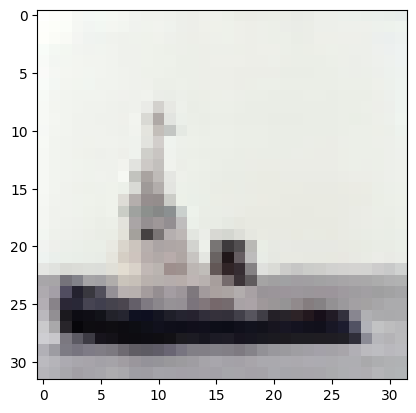

In [127]:
x, label = trainD[np.random.randint(len(trainD))] # 32x32 PIL image, label
plt.imshow(x.permute(1, 2, 0))
print(label, x.size(), type(x))

In [128]:
BATCH_SIZE = 512
DEVICE = torch.accelerator.current_accelerator()

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

In [129]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.labels = {
                    0: "airplane",  
                    1: "automobile", 
                    2: "bird",
                    3: "cat",
                    4: "deer",
                    5: "dog",
                    6: "frog",
                    7: "horse",
                    8: "ship",
                    9: "truck"
                  }
    self.model = nn.Sequential(
      nn.Conv2d(3, 10, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(10, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Flatten(),
      nn.Linear(720, 256),
      nn.ReLU(),

      nn.Linear(256, 10)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [130]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if batch_i % 25 < 1:
      print(f"Batch {batch_i}/{len(dataloader)}, Loss: {loss.item():.4f}")

def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(epochs: int):
  model = Cifar().to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "model_weights.pth")
  print("Done!\n Weights saved to 'model_weights.pth'")
  return accuracies, losses


In [131]:
EPOCHS = 50

acc, loss = fit(EPOCHS)


Starting...

Epoch 1
Batch 0/98, Loss: 2.3022
Batch 25/98, Loss: 1.9940
Batch 50/98, Loss: 1.8966
Batch 75/98, Loss: 1.7589
TEST, Accuracy: 38.55%, Loss: 1.7258

Epoch 2
Batch 0/98, Loss: 1.7046
Batch 25/98, Loss: 1.6286
Batch 50/98, Loss: 1.5583
Batch 75/98, Loss: 1.4994
TEST, Accuracy: 46.15%, Loss: 1.5009

Epoch 3
Batch 0/98, Loss: 1.4823
Batch 25/98, Loss: 1.5047
Batch 50/98, Loss: 1.3944
Batch 75/98, Loss: 1.3833
TEST, Accuracy: 49.37%, Loss: 1.4099

Epoch 4
Batch 0/98, Loss: 1.4278
Batch 25/98, Loss: 1.4127
Batch 50/98, Loss: 1.3785
Batch 75/98, Loss: 1.4242
TEST, Accuracy: 52.37%, Loss: 1.3387

Epoch 5
Batch 0/98, Loss: 1.3836
Batch 25/98, Loss: 1.3417
Batch 50/98, Loss: 1.2207
Batch 75/98, Loss: 1.4398
TEST, Accuracy: 53.90%, Loss: 1.3013

Epoch 6
Batch 0/98, Loss: 1.2277
Batch 25/98, Loss: 1.3325
Batch 50/98, Loss: 1.2321
Batch 75/98, Loss: 1.1900
TEST, Accuracy: 56.29%, Loss: 1.2365

Epoch 7
Batch 0/98, Loss: 1.2254
Batch 25/98, Loss: 1.2318
Batch 50/98, Loss: 1.2133
Batch 75

[38.552, 46.146, 49.368, 52.373999999999995, 53.903999999999996, 56.28999999999999, 57.042, 57.589999999999996, 58.858, 61.248000000000005, 61.79599999999999, 63.160000000000004, 63.99, 65.03, 64.854, 66.464, 67.524, 67.46600000000001, 67.778, 69.174, 69.294, 70.32000000000001, 70.934, 70.538, 71.94, 71.892, 73.49799999999999, 73.832, 74.046, 74.11999999999999, 75.306, 75.356, 75.58399999999999, 75.72, 76.3, 77.28399999999999, 77.876, 77.664, 79.038, 78.19800000000001, 78.55, 79.12599999999999, 79.488, 79.754, 80.2, 80.84599999999999, 81.148, 82.712, 81.446, 82.938]


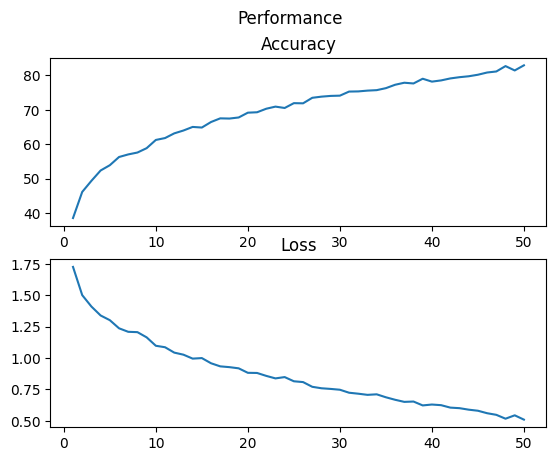

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1.plot(epochs, acc)
ax1.set_title("Accuracy")

ax2.plot(epochs, loss)
ax2.set_title("Loss")
plt.savefig(f"performance_{int(time.time())}")